#  目的
ベースラインの作成

ref: https://huggingface.co/docs/transformers/main/en/tasks/sequence_classification

In [1]:
# path setting
EXP_NAME = "e001-baseline"
MODEL_NAME = "microsoft/deberta-v3-base"
COMPETITION_NAME = "automated_essay_scoring"

# DATA_PATH = f"{COMPETITION_NAME}/data"
DATA_PATH = "data"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"{COMPETITION_NAME}/trained_models/{EXP_NAME}"

# experiment parameter
DEBUG = False
TRAINING = True
UPLOAD_DATA_TO_S3 = True
UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

# model parameter
TRAINING_MAX_LENGTH = 512
SEED = 42
VALID_DATA_SIZE = 0.3
EPOCH = 3
LR = 2e-05
TRAIN_BS = 2
GRAD_ACC_NUM = 8
EVAL_BS = 2
NUM_LABELS = 6

In [2]:
!nvidia-smi

In [3]:
!python --version

In [4]:
# def resolve_path(base_path: str) -> str:
#     import os

#     cwd = os.getcwd()
#     print(cwd)
#     if cwd == "/notebooks":
#         print("Jupyter Kernel By VSCode or nohup!")
#         return base_path
#     elif cwd == f"/notebooks/{COMPETITION_NAME}":
#         print("Jupyter Lab!")
#         return f"../../{base_path}"
#     else:
#         raise Exception("Unknown environment")


# DATA_PATH = resolve_path(DATA_PATH)
# print(DATA_PATH)
# MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
# print(MODEL_OUTPUT_PATH)

In [5]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

# install

In [6]:
%pip install -qq polars==0.20.23
%pip install -qq transformers==4.40.1
%pip install -qq datasets==2.19.0
%pip install -qq evaluate==0.4.2
%pip install -qq seqeval==1.2.2
%pip install -qq accelerate==0.30.0
%pip install -qq python-dotenv==1.0.1
%pip install -qq wandb==0.16.6

# formatter
%pip install -qq black isort

%pip install -qq kaggle

# import

In [7]:
import json
import os
import random

import evaluate
import numpy as np
import polars as pl
import torch
import wandb
from datasets import ClassLabel, DatasetDict, Value, concatenate_datasets, load_dataset
from tokenizers import AddedToken
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from sklearn.metrics import cohen_kappa_score

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROC = os.cpu_count()

In [9]:
import transformers
import datasets
import evaluate

assert transformers.__version__ == "4.40.1"
assert datasets.__version__ == "2.19.0"
assert evaluate.__version__ == "0.4.2"

In [10]:
# Seed the same seed to all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [11]:
from dotenv import load_dotenv

load_dotenv(f"{DATA_PATH}/.env")

True

# Wandb

In [12]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project="automated_essay_scoring", name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

'wandb'

# Data Import

In [13]:
train_dataset = load_dataset(
    "csv",
    data_files={"train": f"{DATA_PATH}/train.csv"},
    split="train",
)

train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'score'],
    num_rows: 17307
})

In [14]:
train_dataset[1]["full_text"]

'I am a scientist at NASA that is discussing the "face" on mars. I will be explaining how the "face" is a land form. By sharing my information about this isue i will tell you just that.\n\nFirst off, how could it be a martions drawing. There is no plant life on mars as of rite now that we know of, which means so far as we know it is not possible for any type of life. That explains how it could not be made by martians. Also why and how would a martion build a face so big. It just does not make any since that a martian did this.\n\nNext, why it is a landform. There are many landforms that are weird here in America, and there is also landforms all around the whole Earth. Many of them look like something we can relate to like a snake a turtle a human... So if there are landforms on earth dont you think landforms are on mars to? Of course! why not? It\'s just unique that the landform on Mars looks like a human face. Also if there was martians and they were trying to get our attention dont y

In [15]:
if DEBUG:
    train_dataset = train_dataset.select(range(300))
    EPOCH = 1

In [16]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [17]:
def preprocess_function(examples):
    return tokenizer(
        examples["full_text"],
        max_length=TRAINING_MAX_LENGTH,
        truncation=True,
        padding="max_length",
    )

In [18]:
train_dataset = train_dataset.map(preprocess_function, batched=True, num_proc=NUM_PROC)

In [19]:
set(train_dataset["score"])

{1, 2, 3, 4, 5, 6}

In [20]:
score2label = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

label2score = {v: k for k, v in score2label.items()}

train_dataset = train_dataset.map(
    lambda examples: {"labels": score2label[examples["score"]]},
    num_proc=NUM_PROC,
)

In [21]:
set(train_dataset["labels"])

{0, 1, 2, 3, 4, 5}

In [22]:
train_test_split_dataset = train_dataset.train_test_split(
    test_size=VALID_DATA_SIZE, seed=SEED
)
train_test_split_dataset

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'full_text', 'score', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 12114
    })
    test: Dataset({
        features: ['essay_id', 'full_text', 'score', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5193
    })
})

In [23]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [24]:
# accuracy = evaluate.load("accuracy")


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return accuracy.compute(predictions=predictions, references=labels)


# https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800
def compute_metrics_for_classification(eval_pred):

    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights="quadratic")
    results = {"qwk": qwk}
    return results


# # TODO: 数値回帰に変更する
# def compute_metrics_for_regression(eval_pred):

#     predictions, labels = eval_pred
#     qwk = cohen_kappa_score(
#         labels, predictions.clip(0, 5).round(0), weights="quadratic"
#     )
#     results = {"qwk": qwk}
#     return results

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=score2label,
    label2id=label2score,
)

In [26]:
assert len(set(train_test_split_dataset["train"]["labels"])) == NUM_LABELS
assert len(set(train_test_split_dataset["test"]["labels"])) == NUM_LABELS

In [27]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_PATH,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    gradient_accumulation_steps=GRAD_ACC_NUM,
    eval_accumulation_steps=GRAD_ACC_NUM,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=0.1,
    save_strategy="steps",
    save_steps=0.1,
    save_total_limit=1,
    seed=SEED,
    metric_for_best_model="qwk",
    warmup_ratio=0.1,
    lr_scheduler_type="cosine_with_restarts",
    report_to=REPORT_TO,
    run_name=EXP_NAME,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split_dataset["train"],
    eval_dataset=train_test_split_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    # compute_metrics=compute_metrics,
    compute_metrics=compute_metrics_for_classification,
)

In [28]:
if TRAINING:
    # モデルの学習
    trainer.train()
    cv_score = trainer.evaluate()["eval_loss"]
    # ログの保存に利用したストレージを削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
    # モデルの保存
    trainer.save_model(MODEL_OUTPUT_PATH)

Step,Training Loss,Validation Loss,Qwk
228,No log,1.104163,0.482984
456,No log,0.933217,0.722659
684,1.190800,0.930012,0.739040
912,1.190800,0.930156,0.733468
1140,0.907800,0.914119,0.766889
1368,0.907800,0.815902,0.780014
1596,0.829800,0.834090,0.800245
1824,0.829800,0.928259,0.774082
2052,0.715800,0.831242,0.796024


# valid_datasetの作成・保存

In [29]:
def get_valid_preds(trainer):
    """
    trainerを用いてvalid_datasetに対する予測を行う
    """
    predictions = trainer.predict(trainer.eval_dataset).predictions
    preds_final = predictions.argmax(-1)

    return preds_final


def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


valid_pred = get_valid_preds(trainer)

valid_pred = [label2score[valid] for valid in valid_pred]

np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction.npy", np.array(valid_pred))

valid_dataset = trainer.eval_dataset.map(
    add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred}
)

Map:   0%|          | 0/5193 [00:00<?, ? examples/s]

In [30]:
valid_dataset.save_to_disk(f"{MODEL_OUTPUT_PATH}/valid_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/5193 [00:00<?, ? examples/s]

# CVの計算

In [31]:
cv_score = cohen_kappa_score(
    valid_dataset["score"], valid_dataset["valid_pred"], weights="quadratic"
)

print(f"CV Score: {cv_score}")

# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

# 混同行列の計算

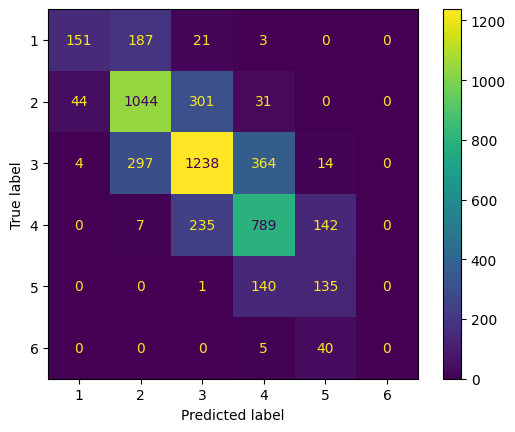

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    valid_dataset["score"], valid_dataset["valid_pred"], labels=[x for x in range(1, 7)]
)

draw_cm = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
)

draw_cm.plot()
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png")
plt.show()

In [33]:
MODEL_OUTPUT_PATH

'automated_essay_scoring/trained_models/e001-baseline'

# AWSへのアップロード

In [34]:
# S3へのアップロード
if UPLOAD_DATA_TO_S3:
    # uninstall
    !sudo rm /usr/bin/aws
    !sudo rm /usr/bin/aws_completer
    !sudo rm -rf /usr/local/aws-cli

    # install
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip -o -qq awscliv2.zip
    !sudo ./aws/install --update

    # upload
    os.system(
        f"aws s3 cp --recursive {MODEL_OUTPUT_PATH} s3://automated-essay-scoring/trained_model/{MODEL_OUTPUT_PATH}"
    )

# Kaggle Datasetへのupload

In [35]:
if UPLOAD_DATA_TO_KAGGLE:
    import os
    import json

    from kaggle.api.kaggle_api_extended import KaggleApi

    os.system("mkdir -p ~/.kaggle/")
    os.system(f"cp /notebooks/{COMPETITION_NAME}/kaggle.json ~/.kaggle/")
    os.system("chmod 600 ~/.kaggle/kaggle.json")

    def dataset_create_new(dataset_name: str, upload_dir: str):
        # if "_" in dataset_name:
        #     raise ValueError("datasetの名称に_の使用は禁止です")
        dataset_metadata = {}
        dataset_metadata["id"] = f"sinchir0/{dataset_name}"
        dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
        dataset_metadata["title"] = dataset_name
        with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")

    print(f"Create Dataset name:{DATASET_NAME}, output_dir:{MODEL_OUTPUT_PATH}")
    dataset_create_new(dataset_name=DATASET_NAME, upload_dir=MODEL_OUTPUT_PATH)

# ローカルからのデータの削除

In [36]:
if UPLOAD_DATA_TO_S3 or UPLOAD_DATA_TO_KAGGLE:
    # ローカルからは削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}")

In [37]:
# TODO: wandbの利用 → Done
# TODO: save_modelする際にs3へ送るように変更 → Done
# TODO: valid_scoreとデータを合わせたCSVの保存 → Done
# TODO: CV計算のために、weighted kappaの実装 → Done
# TODO: Kaggle Datasetへのupload → Done
# TODO: subをする

In [38]:
if WANDB:
    wandb.finish()

In [39]:
print("finish Notebook!")